## Resumo dos Principais Tópicos do Notebook

- **Carregamento e Unificação dos Dados**  
    Os dados de quatro plataformas de streaming (Netflix, HBO Max, Apple TV+ e Prime Video) foram carregados, limpos e unificados em um único DataFrame, permitindo análises comparativas.

- **Análise de Volume e Distribuição**  
    Avaliou-se o volume de títulos por plataforma, mostrando diferenças estratégicas: Prime Video aposta em quantidade, enquanto HBO Max foca em curadoria e qualidade.

- **Qualidade dos Títulos**  
    Foram analisadas as notas médias do IMDb, a concentração de títulos bem avaliados (nota ≥ 7.0) e o ranking de qualidade entre as plataformas.

- **Perfil de Gêneros**  
    O notebook explora o foco de cada plataforma em diferentes gêneros (Drama, Comédia, Ação, etc.), utilizando heatmaps e gráficos de radar para visualizar as preferências.

- **Estratégia Temporal**  
    Os títulos foram categorizados em "Clássicos", "Catálogo Médio" e "Lançamentos", analisando a distribuição temporal do catálogo de cada plataforma.

- **Exclusividade e Compartilhamento de Conteúdo**  
    Analisou-se a exclusividade dos 50 títulos mais votados, mostrando quantos são exclusivos de uma plataforma e quantos estão disponíveis em múltiplas.

- **Distribuição das Notas**  
    Foram criados histogramas para comparar como cada plataforma distribui suas notas, evidenciando diferenças entre estratégias de volume e boutique.

### Relevância

Essas análises permitem entender as estratégias de conteúdo das principais plataformas de streaming, destacando diferenças entre volume e curadoria, preferências de gênero, exclusividade e posicionamento temporal do catálogo. Isso é fundamental para profissionais de dados, marketing e negócios que desejam compreender o mercado de streaming, identificar oportunidades e tomar decisões baseadas em dados.

In [ ]:
%pip install pandas
%pip install numpy 
%pip install matplotlib
%pip install seaborn

In [22]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [23]:
# Configuração visual
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [24]:
# Carregar cada CSV limpo
df_netflix = pd.read_csv('C:/Users/nise_/OneDrive/Documentos/Digital College/Python/DA_18/streaming/Dados_tratados/data_netflix_clean.csv')
df_hbo = pd.read_csv('C:/Users/nise_/OneDrive/Documentos/Digital College/Python/DA_18/streaming/Dados_tratados/data_hbo_clean.csv')
df_apple = pd.read_csv('C:/Users/nise_/OneDrive/Documentos/Digital College/Python/DA_18/streaming/Dados_tratados/df_apple_clean.csv')
df_prime = pd.read_csv('C:/Users/nise_/OneDrive/Documentos/Digital College/Python/DA_18/streaming/Dados_tratados/data_prime_video_clean.csv')


print("📂 DATASETS CARREGADOS:")
print(f"Netflix: {len(df_netflix):,} registros")
print(f"HBO Max: {len(df_hbo):,} registros") 
print(f"Apple TV: {len(df_apple):,} registros")
print(f"Prime Video: {len(df_prime):,} registros")

📂 DATASETS CARREGADOS:
Netflix: 21,391 registros
HBO Max: 9,776 registros
Apple TV: 18,692 registros
Prime Video: 72,943 registros


In [25]:
# Adicionar coluna de plataforma
df_netflix['platform'] = 'Netflix'
df_hbo['platform'] = 'HBO Max'
df_apple['platform'] = 'Apple TV+'
df_prime['platform'] = 'Prime Video'

In [26]:

# ==========================================
# UNINDO OS DATASETS
# ==========================================

platforms = {
    'Netflix': df_netflix,
    'HBO Max': df_hbo, 
    'Apple TV': df_apple,
    'Prime Video': df_prime
}
# Concatenar todos os DataFrames em um único DataFrame
df_streaming = pd.concat([df_netflix, df_hbo, df_apple, df_prime], ignore_index=True)


print(f"\n🎬 DATASET UNIFICADO CRIADO:")
print(f"Total de registros: {len(df_streaming):,}")
print(f"Total de colunas: {len(df_streaming.columns)}")
print(f"Colunas: {list(df_streaming.columns)}")



🎬 DATASET UNIFICADO CRIADO:
Total de registros: 122,802
Total de colunas: 8
Colunas: ['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating', 'imdbNumVotes', 'platform']


In [27]:

# ==========================================
# VERIFICAÇÃO RÁPIDA
# ==========================================

print(f"\n📊 DISTRIBUIÇÃO POR PLATAFORMA:")
platform_counts = df_streaming['platform'].value_counts()
for platform, count in platform_counts.items():
    percentage = (count / len(df_streaming)) * 100
    print(f"  {platform}: {count:,} ({percentage:.1f}%)")


📊 DISTRIBUIÇÃO POR PLATAFORMA:
  Prime Video: 72,943 (59.4%)
  Netflix: 21,391 (17.4%)
  Apple TV+: 18,692 (15.2%)
  HBO Max: 9,776 (8.0%)


In [28]:
# Top filmes por plataforma (nota >= 7.0)
high_rated = df_streaming[df_streaming['imdbAverageRating'] >= 7.0]
concentration_analysis = high_rated.groupby('platform').agg({
    'title': 'count',
    'imdbAverageRating': ['mean', 'median']
}).round(2)

# Ranking das plataformas por qualidade
platform_quality_ranking = df_streaming.groupby('platform')['imdbAverageRating'].mean().sort_values(ascending=False)


In [29]:

print("Análise de concentração de filmes bem avaliados por plataforma:")
display(concentration_analysis)

print("\nRanking das plataformas por nota média IMDb:")
display(platform_quality_ranking)


Análise de concentração de filmes bem avaliados por plataforma:


title imdbAverageRating       
             count              mean median
platform                                   
Apple TV+     6098              7.57    7.5
HBO Max       3998              7.59    7.5
Netflix       7009              7.55    7.4
Prime Video  18088              7.53    7.4


Ranking das plataformas por nota média IMDb:


platform
HBO Max        6.698885
Netflix        6.434975
Apple TV+      6.411815
Prime Video    5.999097
Name: imdbAverageRating, dtype: float64

In [30]:
# Análise de gêneros dominantes por plataforma
def analyze_genre_focus(df, genres_list=['Drama', 'Comedy', 'Action', 'Horror', 'Romance', 
                  'Thriller', 'Documentary', 'Animation', 'Crime', 'Adventure']):
    genre_analysis = {}
    for genre in genres_list:
        genre_mask = df['genres'].str.contains(genre, case=False, na=False)
        genre_counts = df[genre_mask]['platform'].value_counts()
        genre_percentages = (genre_counts / df['platform'].value_counts() * 100).round(1)
        genre_analysis[genre] = genre_percentages
    return pd.DataFrame(genre_analysis).fillna(0)

genre_focus_matrix = analyze_genre_focus(df_streaming)


In [31]:
# Perfil completo por plataforma
platform_profiles = df_streaming.groupby('platform').agg({
    'releaseYear': ['mean', 'median', 'min', 'max'],
    'imdbAverageRating': ['mean', 'median', 'std'],
    'imdbNumVotes': ['mean', 'median'],
    'title': 'count'
}).round(2)

# Gêneros mais comuns por plataforma
def get_top_genres_by_platform(df, top_n=5):
    platform_genres = {}
    for platform in df['platform'].unique():
        platform_data = df[df['platform'] == platform]
        all_genres = []
        for genres_str in platform_data['genres'].dropna():
            all_genres.extend([g.strip() for g in str(genres_str).split(',')])
        genre_counts = Counter(all_genres)
        platform_genres[platform] = dict(genre_counts.most_common(top_n))
    return platform_genres


In [32]:
# Definir períodos
current_year = 2025
classic_threshold = current_year - 20  # Filmes antes de 2005
recent_threshold = current_year - 5    # Filmes após 2020

# Categorizar títulos
df_streaming['era_category'] = pd.cut(
    df_streaming['releaseYear'], 
    bins=[0, classic_threshold, recent_threshold, current_year + 1],
    labels=['Clássicos', 'Catálogo Médio', 'Lançamentos']
)

# Estratégia por plataforma
era_strategy = df_streaming.groupby(['platform', 'era_category']).size().unstack(fill_value=0)
era_percentages = era_strategy.div(era_strategy.sum(axis=1), axis=0) * 100


C:\Users\nise_\AppData\Local\Temp\ipykernel_98832\807267156.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  era_strategy = df_streaming.groupby(['platform', 'era_category']).size().unstack(fill_value=0)


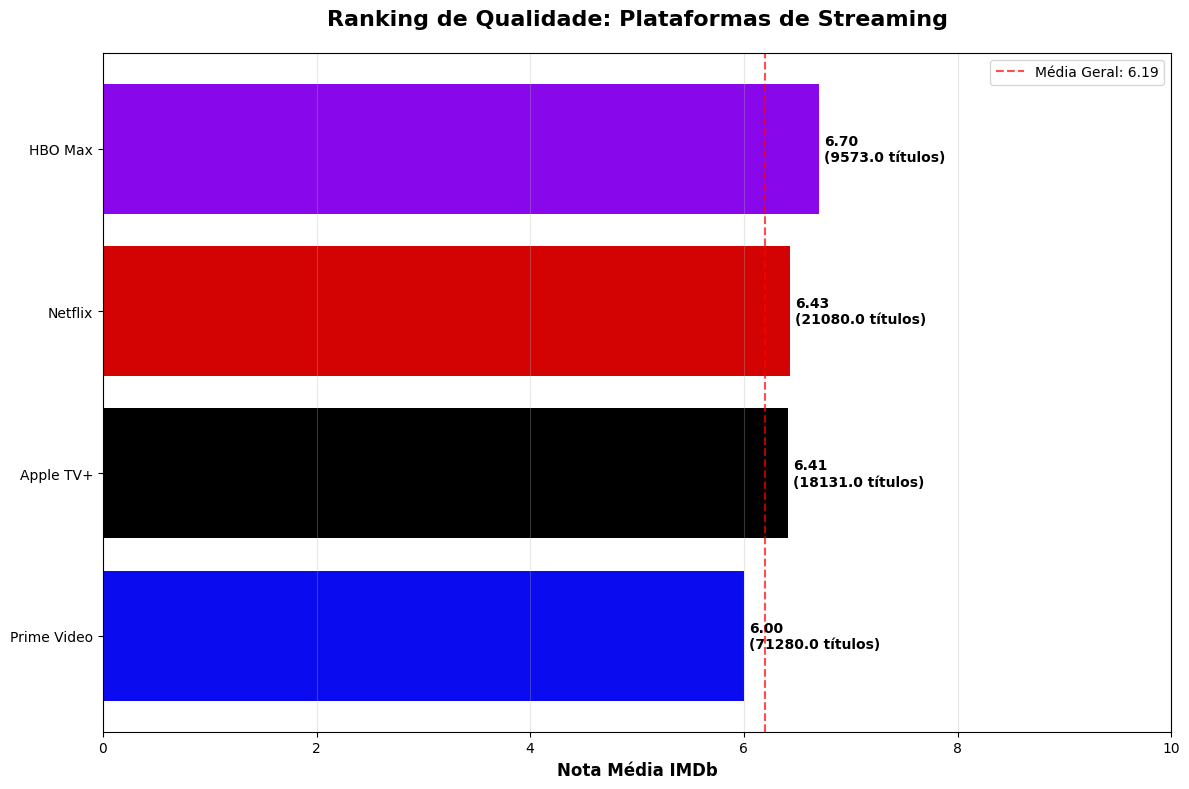

In [34]:
# Agrupar e preparar dados
quality_data = (
    df_streaming.groupby('platform')
    .agg(avg_rating=('imdbAverageRating', 'mean'),
         total_titles=('title', 'count'))
    .round(2)
    .sort_values('avg_rating')
)

# Visualização
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(quality_data.index, quality_data['avg_rating'],
               color=["#0B0BF0", "#000000", "#D30303", "#8808EB"])

for i, (platform, row) in enumerate(quality_data.iterrows()):
    ax.text(row['avg_rating'] + 0.05, i,
            f"{row['avg_rating']:.2f}\n({row['total_titles']} títulos)",
            va='center', fontweight='bold', fontsize=10)

overall_avg = df_streaming['imdbAverageRating'].mean()
ax.axvline(overall_avg, color='red', linestyle='--', alpha=0.7,
           label=f'Média Geral: {overall_avg:.2f}')

ax.set_xlabel('Nota Média IMDb', fontsize=12, fontweight='bold')
ax.set_title('Ranking de Qualidade: Plataformas de Streaming',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlim(0, 10)
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
def plot_radar_genre(genre_focus):
    """4 radares limpos com código mínimo"""
    genres = ['Drama', 'Comedy', 'Action', 'Horror', 'Romance', 'Documentary']
    angles = np.linspace(0, 2*np.pi, len(genres), endpoint=False).tolist() + [0]
    colors = ['#000000', '#9146FF', '#E50914', '#00A8E1']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw=dict(projection='polar'))
    
    for i, (platform, ax) in enumerate(zip(genre_focus.index, axes.flat)):
        values = genre_focus.loc[platform, genres].tolist() + [genre_focus.loc[platform, genres].iloc[0]]
        
        ax.plot(angles, values, 'o-', linewidth=3, color=colors[i])
        ax.fill(angles, values, alpha=0.3, color=colors[i])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(genres, fontsize=10)
        ax.set_title(platform, fontsize=14, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Perfil de Gêneros por Plataforma', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


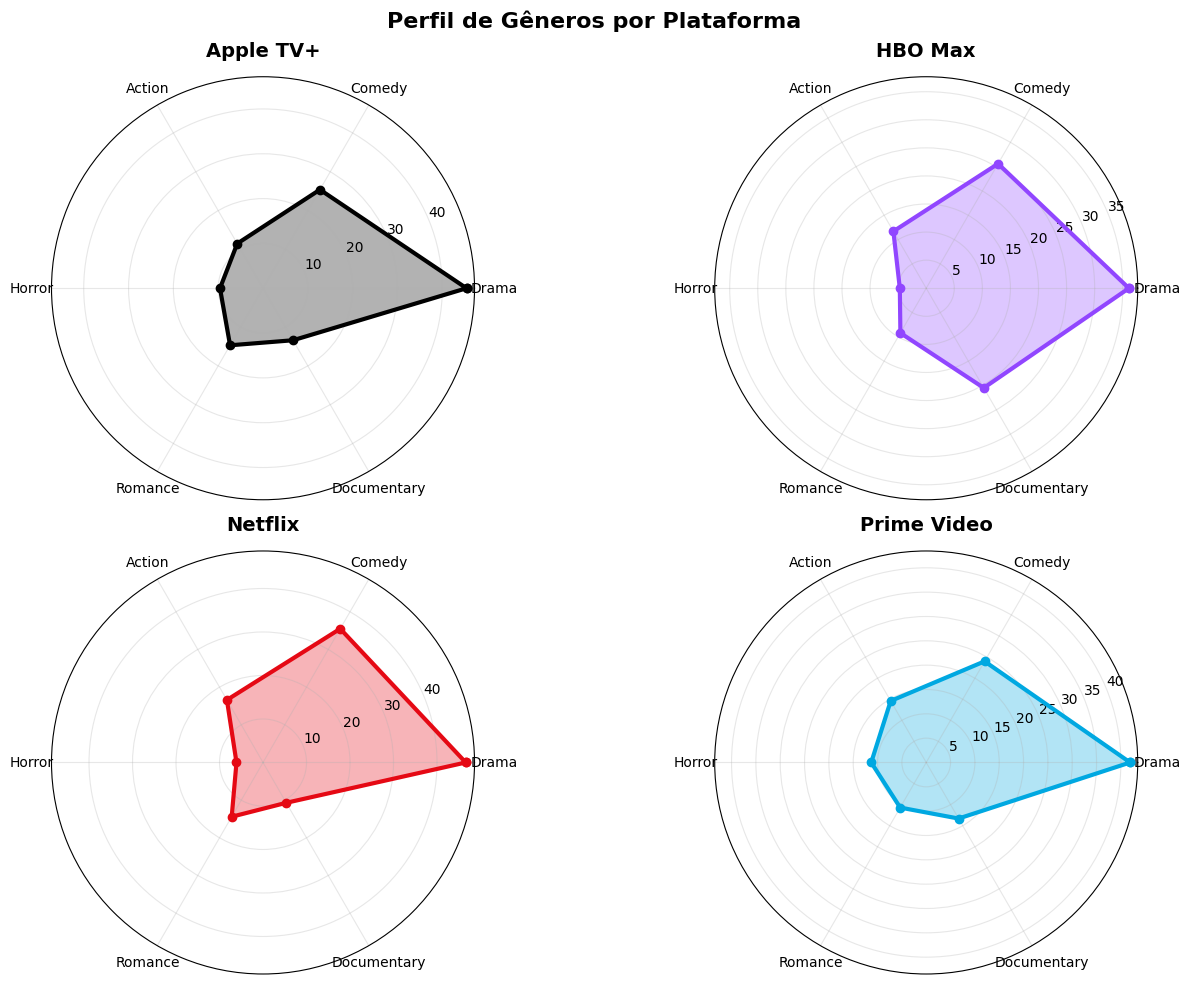

In [20]:
# Plotar radar de gêneros
plot_radar_genre(genre_focus_matrix)

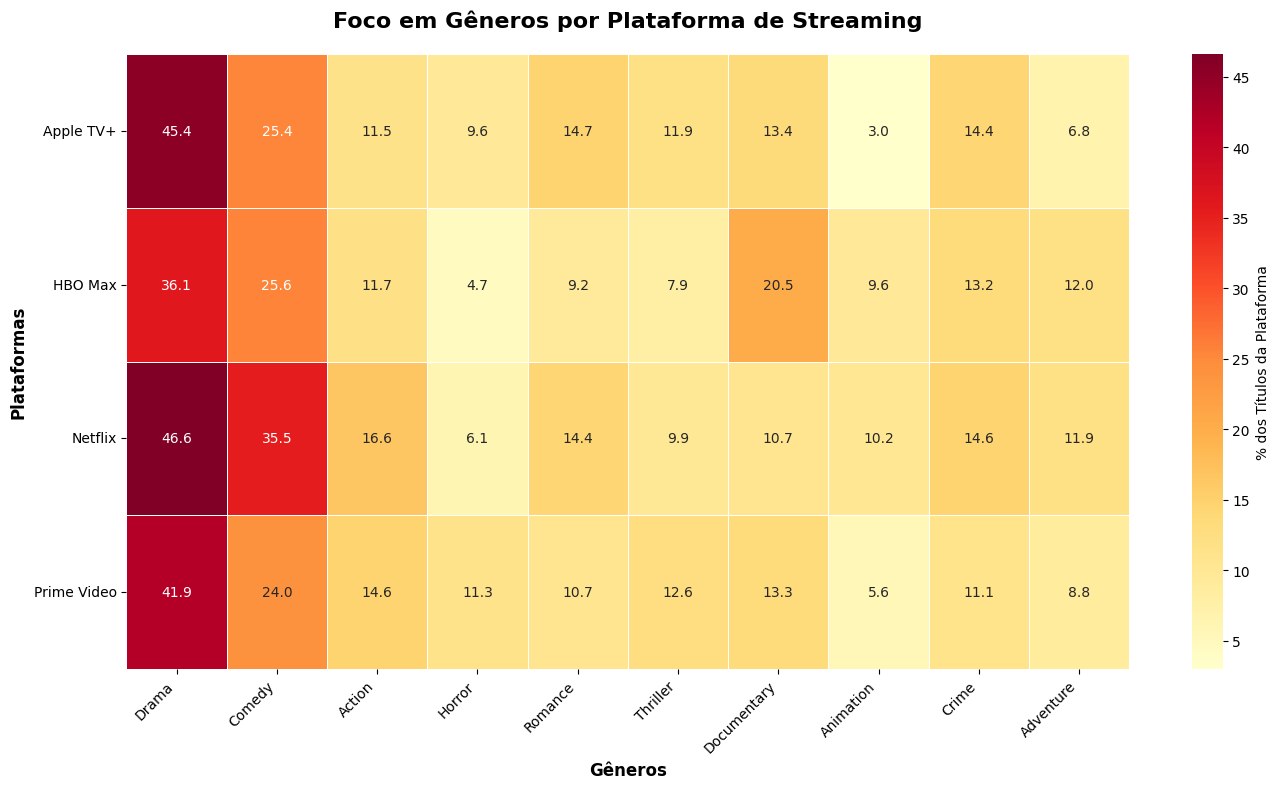

In [21]:
# Visualização
fig, ax = plt.subplots(figsize=(14, 8))

# Heatmap com anotações usando genre_focus_matrix (já criado pela função analyze_genre_focus)
sns.heatmap(genre_focus_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': '% dos Títulos da Plataforma'},
            linewidths=0.5, ax=ax)

ax.set_title('Foco em Gêneros por Plataforma de Streaming', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Gêneros', fontsize=12, fontweight='bold')
ax.set_ylabel('Plataformas', fontsize=12, fontweight='bold')

# Rotacionar labels para melhor leitura
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

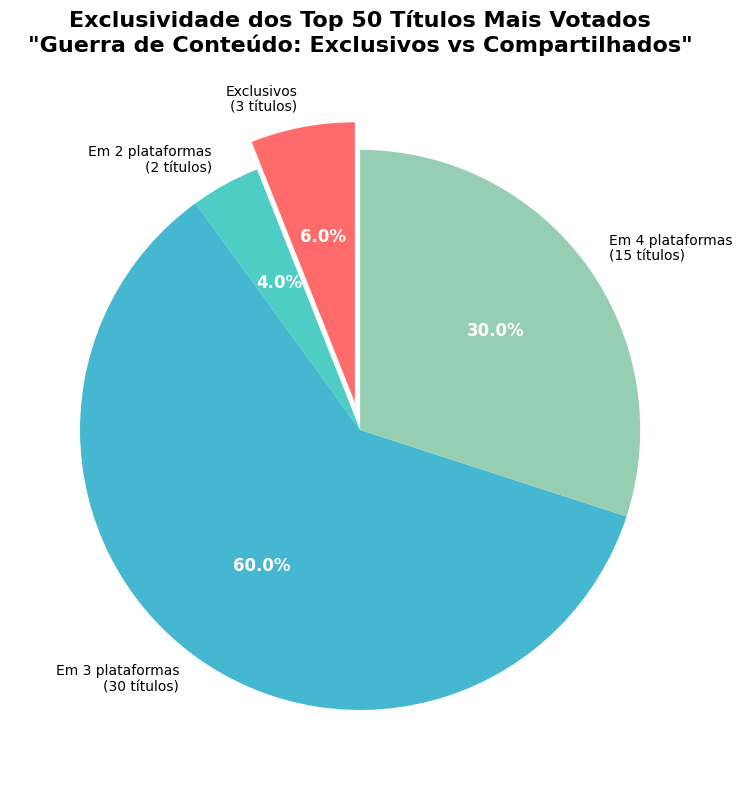

In [35]:
# Exclusividade dos top 50 títulos mais votados
top50 = df_streaming.nlargest(50, 'imdbNumVotes')
exclusivity = (
    top50.merge(
        df_streaming.groupby('title')['platform'].nunique().rename('num_platforms'),
        on='title'
    )
    .groupby('num_platforms')['title'].count()
    .sort_index()
)

labels = [
    f'Exclusivos\n({exclusivity.get(1,0)} títulos)' if n == 1 else f'Em {n} plataformas\n({c} títulos)'
    for n, c in exclusivity.items()
]
sizes = exclusivity.values
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

fig, ax = plt.subplots(figsize=(12, 8))
wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90,
    explode=[0.1 if n == 1 else 0 for n in exclusivity.index]
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

ax.set_title('Exclusividade dos Top 50 Títulos Mais Votados\n"Guerra de Conteúdo: Exclusivos vs Compartilhados"',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [132]:
def categorize_strategy(df_streaming, classic_years=20, recent_years=5):
    """
    Função simples: ano + avaliação = categoria estratégica
    """
    current_year = 2024
    
    def get_category(year, rating):
        if pd.isna(year) or pd.isna(rating):
            return 'Neutro'
        
        if year <= (current_year - classic_years):
            return 'Clássico'
        elif year >= (current_year - recent_years):
            return 'Lançamento'
        else:
            return 'Neutro'
    
    # Aplicar categorização
    df_streaming['category'] = df_streaming.apply(
        lambda row: get_category(row['releaseYear'], row['imdbAverageRating']), axis=1
    )
    
    # Calcular percentuais por plataforma
    result = df_streaming.groupby(['platform', 'category']).size().unstack(fill_value=0)
    result_pct = result.div(result.sum(axis=1), axis=0) * 100
    
    return result_pct

In [ ]:
def plot_bars_strategy(strategy_data):
    # Função para plotar gráfico de barras
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Dados para as barras
    platforms = strategy_data.index
    classics = strategy_data['Clássico']
    launches = strategy_data['Lançamento']
    
    x = np.arange(len(platforms))
    width = 0.35
    
    # Barras
    bars1 = ax.bar(x - width/2, classics, width, label='Clássicos', 
                   color="#113BC5", alpha=0.8)
    bars2 = ax.bar(x + width/2, launches, width, label='Lançamentos', 
                   color="#0FCBF5", alpha=0.8)
    
    # Valores nas barras
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax.set_xlabel('Plataformas', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentual do Catálogo (%)', fontsize=12, fontweight='bold')
    ax.set_title('Estratégia Temporal: Clássicos vs Lançamentos', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(platforms)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

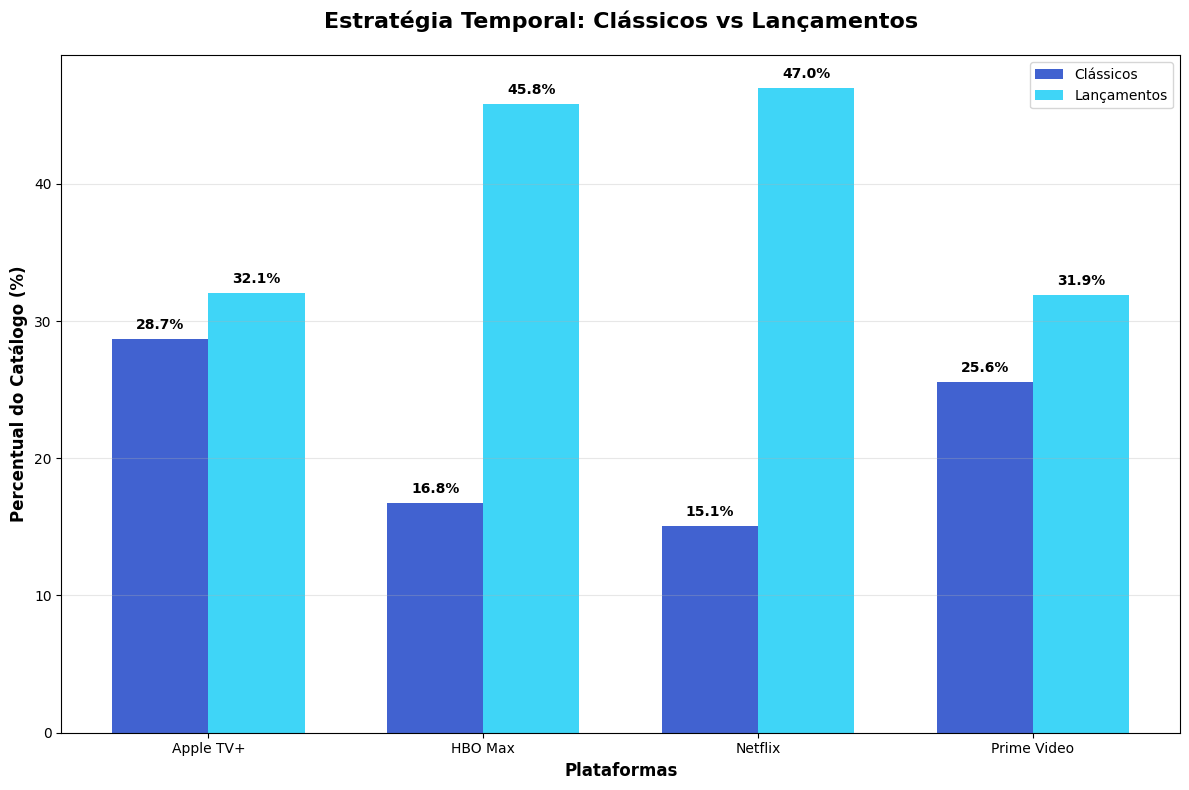

category     Clássico  Lançamento  Neutro
platform                                 
Apple TV+        28.7        32.1    39.2
HBO Max          16.8        45.8    37.4
Netflix          15.1        47.0    37.9
Prime Video      25.6        31.9    42.5


In [ ]:
# Usando a função para categorizar e plotar
strategy_pct = categorize_strategy(df_streaming)
plot_bars_strategy(strategy_pct)
print(strategy_pct.round(1))

In [135]:
def plot_distribution_histogram(df_streaming):
    """Histograma mostra quantos filmes em cada faixa de nota"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    df_clean = df_streaming[['platform', 'imdbAverageRating']].dropna()
    
    # Criar bins para as notas
    bins = np.arange(1, 11, 0.5)  # Bins de 0.5 em 0.5
    
    # Dados por plataforma
    netflix_data = df_clean[df_clean['platform'] == 'Netflix']['imdbAverageRating']
    hbo_data = df_clean[df_clean['platform'] == 'HBO Max']['imdbAverageRating']
    apple_data = df_clean[df_clean['platform'] == 'Apple TV+']['imdbAverageRating']
    prime_data = df_clean[df_clean['platform'] == 'Prime Video']['imdbAverageRating']
    
    # Histograma empilhado
    ax.hist([netflix_data, hbo_data, apple_data, prime_data], 
            bins=bins, alpha=0.8, 
            label=['Netflix', 'HBO Max', 'Apple TV+', 'Prime Video'],
            color=['#E50914', '#9146FF', '#000000', '#00A8E1'])
    
    ax.set_xlabel('Nota IMDb', fontsize=12, fontweight='bold')
    ax.set_ylabel('Número de Filmes', fontsize=12, fontweight='bold')
    ax.set_title('Distribuição por Faixas de Nota\nQuantos filmes cada plataforma tem em cada nota', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


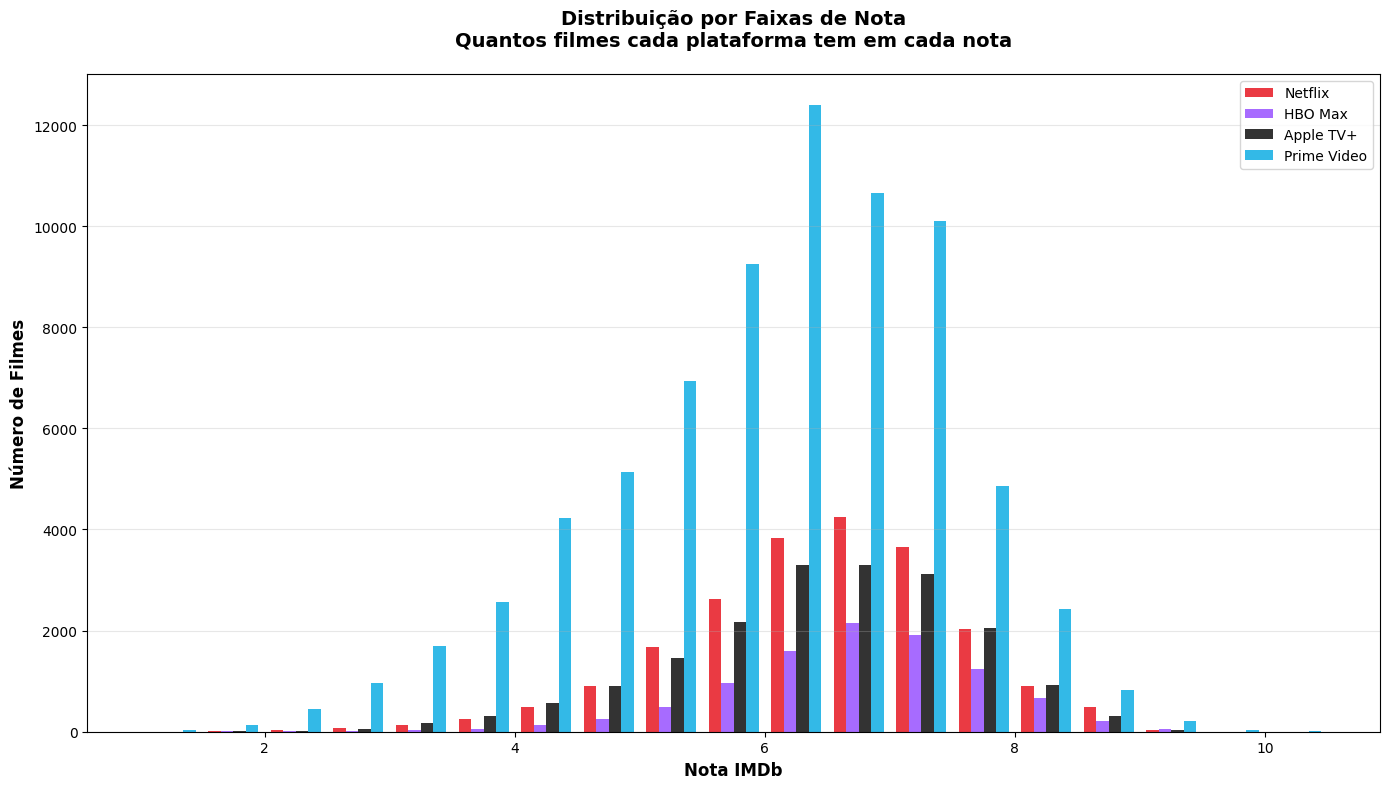

In [136]:
#usando a função plot_distribution_histogram
plot_distribution_histogram(df_streaming)

## Prime Video (Estratégia de Volume): ##

72.943 títulos (59.4% do dataset total)

Muitos filmes na faixa 6.0-7.0 (bem avaliados, mas não excepcionais)

Poucos filmes realmente ruins (abaixo de 5.0)

Poucos filmes excepcionais (acima de 8.0)

Resultado: Média "puxada para baixo" pelo volume de conteúdo mediano

## HBO Max (Estratégia Boutique): ##

9.776 títulos (apenas 8% do dataset)

Curadoria mais seletiva

Menos volume, mas maior concentração de títulos de qualidade superior

Resultado: Média mais alta

## Analogia Simples ##
É como comparar um supermercado (Prime Video) com uma delicatessen (HBO Max):

Supermercado: Tem de tudo, muita coisa boa, algumas ruins, média geral OK

Delicatessen: Só produtos selecionados, média de qualidade mais alta

Prime Video aposta na abundância - "temos algo para todo mundo". HBO Max aposta na exclusividade - "temos o melhor conteúdo".

Ambas as estratégias funcionam, mas para públicos diferentes. Prime Video satisfaz quem quer variedade, HBO Max satisfaz quem quer qualidade premium.

C:\Users\nise_\AppData\Local\Temp\ipykernel_69916\3759149268.py:45: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\nise_\OneDrive\Documentos\Digital College\Python\DA_18\streaming\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


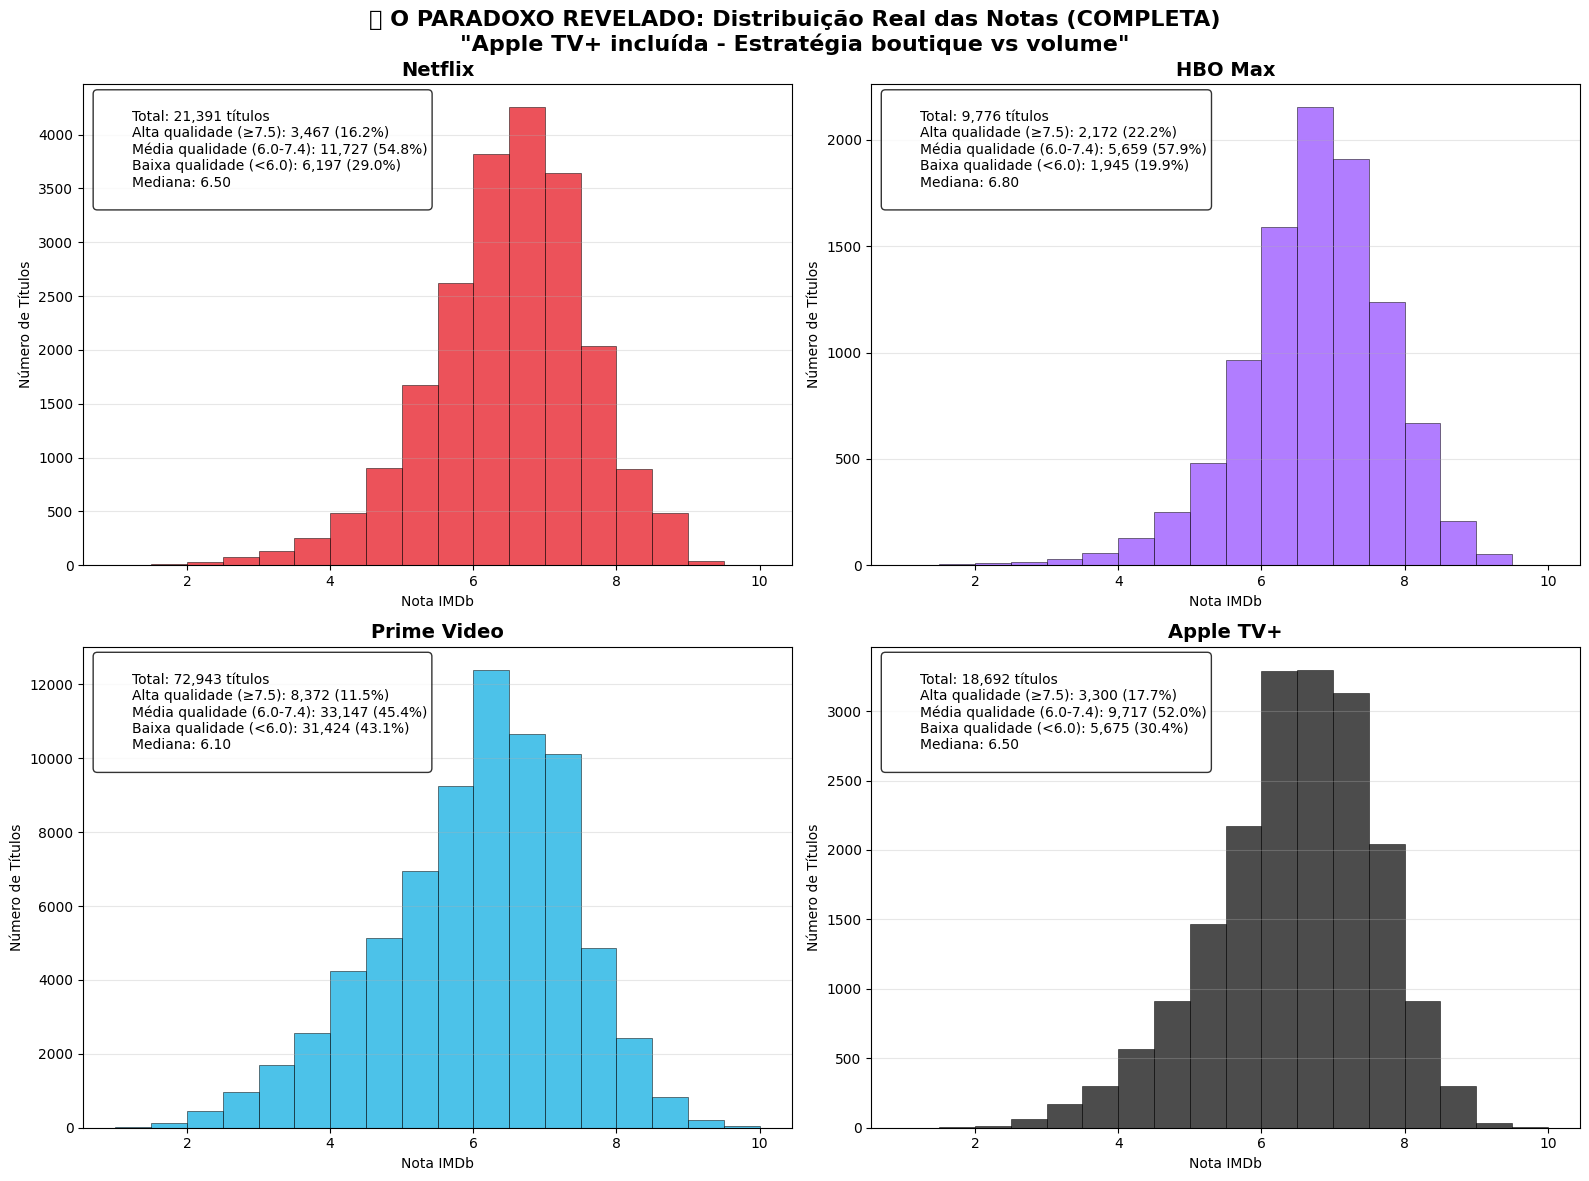

In [137]:
def plot_quality_distribution_comparison_complete(df_streaming):
    """Mostra COMO cada plataforma distribui suas notas - TODAS as 4 plataformas"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    platforms = ['Netflix', 'HBO Max', 'Prime Video', 'Apple TV+']  # Todas as 4!
    colors = ['#E50914', '#9146FF', '#00A8E1', '#000000']
    
    # Criar bins de qualidade
    bins = np.arange(1, 10.5, 0.5)
    
    for i, platform in enumerate(platforms):
        ax = axes[i//2, i%2]
        data = df_streaming[df_streaming['platform'] == platform]['imdbAverageRating'].dropna()
        
        # Histograma
        counts, _, _ = ax.hist(data, bins=bins, alpha=0.7, color=colors[i], 
                              edgecolor='black', linewidth=0.5)
        
        # Estatísticas importantes
        total = len(data)
        high_quality = len(data[data >= 7.5])
        medium_quality = len(data[(data >= 6.0) & (data < 7.5)])
        low_quality = len(data[data < 6.0])
        
        # Adicionar texto explicativo
        stats_text = f"""
        Total: {total:,} títulos
        Alta qualidade (≥7.5): {high_quality:,} ({high_quality/total*100:.1f}%)
        Média qualidade (6.0-7.4): {medium_quality:,} ({medium_quality/total*100:.1f}%)
        Baixa qualidade (<6.0): {low_quality:,} ({low_quality/total*100:.1f}%)
        Mediana: {data.median():.2f}
        """
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        ax.set_title(f'{platform}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Nota IMDb')
        ax.set_ylabel('Número de Títulos')
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('🔍 O PARADOXO REVELADO: Distribuição Real das Notas (COMPLETA)\n"Apple TV+ incluída - Estratégia boutique vs volume"', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Executar
plot_quality_distribution_comparison_complete(df_streaming)
